In [159]:


import pytest
import os
import numpy as np
import copy
from onnx import TensorProto, helper
from qonnx.core.datatype import DataType
from qonnx.core.modelwrapper import ModelWrapper
from qonnx.custom_op.registry import getCustomOp
from qonnx.transformation.general import GiveUniqueNodeNames
from qonnx.util.basic import qonnx_make_model

from finn.util.fpgadataflow import is_fpgadataflow_node

from finn.analysis.fpgadataflow.exp_cycles_per_layer import exp_cycles_per_layer
from finn.transformation.fpgadataflow.create_dataflow_partition import (
    CreateDataflowPartition,
)
import finn.transformation.fpgadataflow.convert_to_hw_layers as to_hw
from finn.transformation.fpgadataflow.set_folding import SetFolding
from finn.util.test import load_test_checkpoint_or_skip

from qonnx.util.basic import (
    calculate_signed_dot_prod_range,
    gen_finn_dt_tensor,
)
from qonnx.custom_op.general.im2col import compute_conv_output_dim
from qonnx.custom_op.general.multithreshold import multithreshold
from finn.transformation.fpgadataflow.insert_dwc import InsertDWC

from finn.transformation.fpgadataflow.prepare_cppsim import PrepareCppSim
from finn.transformation.fpgadataflow.prepare_ip import PrepareIP
from finn.transformation.fpgadataflow.prepare_rtlsim import PrepareRTLSim
from finn.transformation.fpgadataflow.set_exec_mode import SetExecMode
from finn.transformation.fpgadataflow.set_fifo_depths import InsertAndSetFIFODepths
from finn.transformation.fpgadataflow.specialize_layers import SpecializeLayers
from finn.transformation.fpgadataflow.annotate_cycles import AnnotateCycles
from finn.transformation.fpgadataflow.compile_cppsim import CompileCppSim
from finn.transformation.fpgadataflow.hlssynth_ip import HLSSynthIP
from finn.transformation.fpgadataflow.create_stitched_ip import CreateStitchedIP
import finn.core.onnx_exec as oxe

from qonnx.custom_op.general.im2col import compute_conv_output_dim
from qonnx.custom_op.registry import getCustomOp
from qonnx.transformation.general import GiveUniqueNodeNames
from qonnx.transformation.infer_datatypes import InferDataTypes
from qonnx.transformation.infer_shapes import InferShapes
from qonnx.transformation.lower_convs_to_matmul import LowerConvsToMatMul
from finn.util.platforms import DEFAULT_RES_LIMITS, platforms

import os
import json

import matplotlib.pyplot as plt
import numpy as np

In [160]:
def extract_resources(model,platform,device_count,gen_type,rep_type="post_synth_resources"):


    limits = DEFAULT_RES_LIMITS
    max_luts = limits[0] * sum(
        [
            r["LUT"]
            for r in platforms[platform](device_count).resource_count_dict.values()
        ]
    )
    max_bram = limits[2] * sum(
        [
            r["BRAM_18K"]
            for r in platforms[platform](device_count).resource_count_dict.values()
        ]
    )
    max_uram = limits[3] * sum(
        [
            r["URAM"]
            for r in platforms[platform](device_count).resource_count_dict.values()
        ]
    )
    max_dsp = limits[4] * sum(
        [
            r["DSP"]
            for r in platforms[platform](device_count).resource_count_dict.values()
        ]
    )

    build_dir = os.environ["FINN_BUILD_DIR"]
    test = f"{model}_{platform}"
    dir = f'{build_dir}/../projects/finn/finn-examples/build/{test}_{gen_type}'
    with open(dir+f"/report/{rep_type}.json") as f:
        rep = json.load(f)

    with open(dir+f"/report/estimate_network_performance.json") as f:
        throughput_rep = json.load(f)

    res_types = ["LUT", "BRAM_18K","BRAM_36K","URAM","DSP"]
    total = {}
    dwc = {}
    fifo = {}
    rest = {}
    rtl_dwcs = 0
    hls_dwcs = 0
    dwc["LUT"] = 0
    fifo["LUT"] = 0
    fifo["BRAM_18K"] = 0
    fifo["BRAM_36K"] = 0
    fifo["URAM"] = 0
    fifo["DSP"] = 0

    for val in res_types:
        total[val] = 0
        dwc[val] = 0
        rest[val] = 0


    throughput = throughput_rep["estimated_throughput_fps"]
    latency = throughput_rep["estimated_latency_ns"]
    max_cycles_node = throughput_rep["max_cycles_node_name"]

    

    for key in rep.keys():
        if "(top)" not in key:
            for res_type in res_types:
                if "DataWidthConverter_hls" in key or "DataWidthConverter_rtl" in key:
                    if res_type in rep[key]:
                        dwc[res_type] += int(rep[key][res_type])      
                        total[res_type] += int(rep[key][res_type])
                        if "DataWidthConverter_hls" in key:
                            hls_dwcs += 1
                        else:
                            rtl_dwcs +=1

                elif "StreamingFIFO_hls" in key or "StreamingFIFO_rtl" in key:
                    if res_type in rep[key]:
                        fifo[res_type] += int(rep[key][res_type])      
                        total[res_type] += int(rep[key][res_type])

                else:
                    if res_type in rep[key]:
                        rest[res_type] += int(rep[key][res_type])
                        total[res_type] += int(rep[key][res_type])

    total["BRAM_18K"] = total["BRAM_18K"] + total["BRAM_36K"]*2
    #total["BRAM"] 
    total["LUT"] /= max_luts
    dwc["LUT"] /= max_luts
    fifo["LUT"] /= max_luts
    fifo["BRAM_18K"] /= max_bram
    fifo["URAM"] /= max_uram

    total["DSP"] /= max_dsp
    total["BRAM_18K"] /= max_bram
    total["URAM"] /= max_uram

    total["LUT"] = np.round(100*total["LUT"],1)
    dwc["LUT"] = np.round(100*dwc["LUT"],1)
    fifo["LUT"] = np.round(100*fifo["LUT"],1)
    fifo["BRAM_18K"] = np.round(100*fifo["BRAM_18K"],1)
    fifo["URAM"] = np.round(100*fifo["URAM"],1)
    total["DSP"] = np.round(100*total["DSP"],1)
    total["BRAM_18K"] = np.round(100*total["BRAM_18K"],1)
    total["URAM"] = np.round(100*total["URAM"],1)

    return {"total":total,
            "dwc":dwc,
            "fifo":fifo,
            "rest":rest, 
            "rtl_dwcs":rtl_dwcs, 
            "hls_dwcs": hls_dwcs,
            "throughput":throughput, 
            "latency":latency, 
            "max_cycles_node":max_cycles_node}

vgg10-radioml/output_radioml_w4a4_small_tidy ZCU104


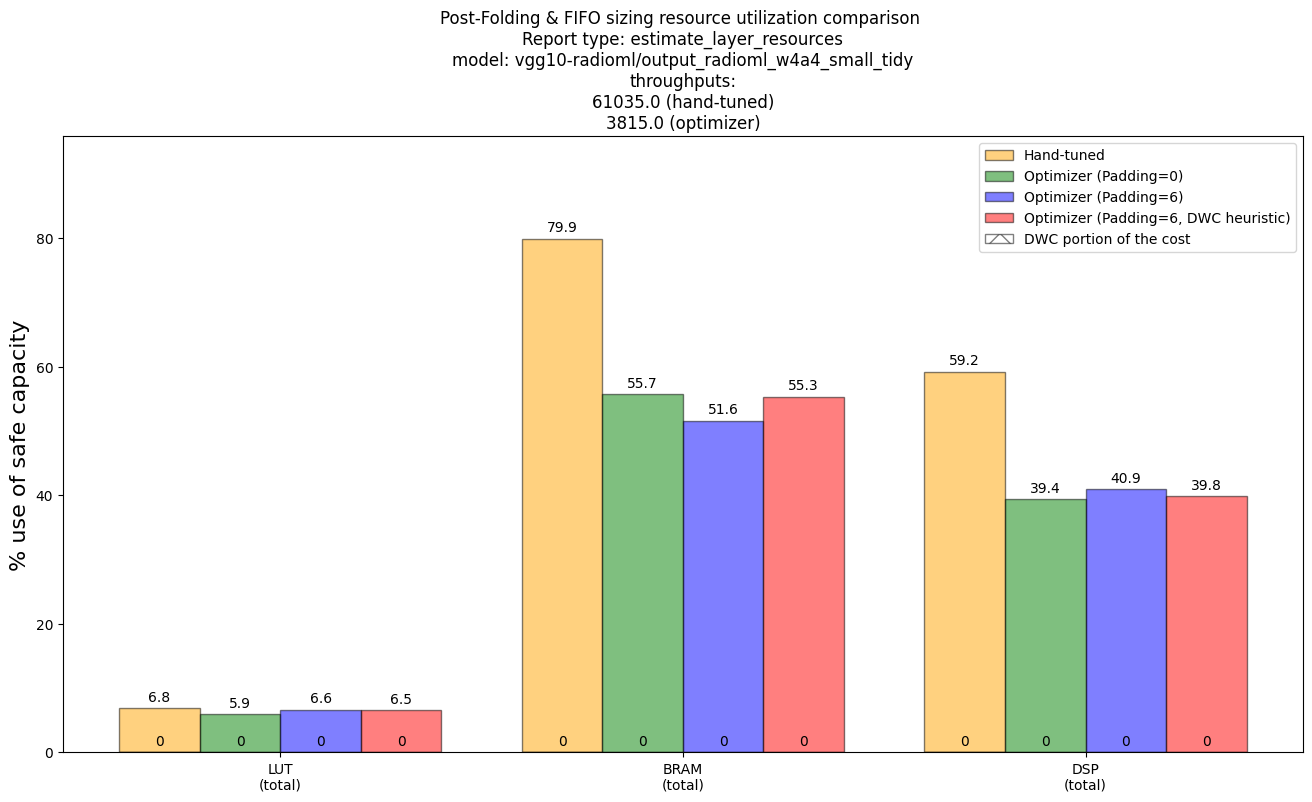

In [180]:

DUTs = []

"cd /scratch/users/lstasyti/projects/finn/finn-examples/build/bnn-pynq"
"cd /scratch/users/lstasyti/projects/finn/finn-examples/build/kws"
"cd /scratch/users/lstasyti/projects/finn/finn-examples/build/gtsrb"
"cd /scratch/users/lstasyti/projects/finn/finn-examples/build/vgg10-radioml"
"cd /scratch/users/lstasyti/projects/finn/finn-examples/build/mobilenet-v1"

# Default Estimate:                      python build.py 0 0 0 2 0 0
# Optimized Estimate:                    python build.py 2 0 0 2 0 0
# Optimized Padded Estimate:             python build.py 2 0 0 2 6 0
# Optimized Padded and DWC'd Estimate:   python build.py 2 0 0 2 6 1

# Default bitstream:                     python build.py 0 2 0 2 0 0
# Optimized bitstream:                   python build.py 2 2 0 2 0 0
# Optimized Padded bitstream:            python build.py 2 2 0 2 6 0
# Optimized Padded and DWC'd bitstream:  python build.py 2 2 0 2 6 1



# CONFIGS

# bnn
#DUTs.append(("Pynq-Z1", "bnn-pynq/output_cnv-w2a2"))
#DUTs.append(("Ultra96", "bnn-pynq/output_cnv-w2a2"))
#DUTs.append(("Ultra96", "bnn-pynq/output_cnv-w1a1"))
#DUTs.append(("Ultra96", "bnn-pynq/output_tfc-w2a2"))
# vgg10 
DUTs.append(("ZCU104","vgg10-radioml/output_radioml_w4a4_small_tidy"))

#kws model
#DUTs.append(("Pynq-Z1","kws/output_MLP_W3A3_python_speech_features_pre-processing_QONNX"))

#gtsrb model
#DUTs.append(("Pynq-Z1","gtsrb/output_cnv_1w1a_gtsrb"))

#mobilenet-v1 model
#DUTs.append(("ZCU104", "mobilenet-v1/output_mobilenetv1-w4a4"))



device_count = 1

rep_type = "estimate_layer_resources"
#rep_type = "post_synth_resources"


for (platform,model) in DUTs:
    print(model,platform)

    variations = ["default","optimized_0_0","optimized_6_0","optimized_6_1"]
    
    resources = [extract_resources(model,platform,device_count,x,rep_type) for x in variations]
   # default = extract_resources(model,platform,device_count,"default",rep_type)
    #optimized = extract_resources(model,platform,device_count,"optimized",rep_type)

    

    fig, ax = plt.subplots()
    #res = "LUT"
    

    default = [resources[0]["total"]["LUT"],
               resources[0]["total"]["BRAM_18K"],
               resources[0]["total"]["DSP"]]
              # resources[0]["dwc"]["LUT"],
              # resources[0]["fifo"]["LUT"],
              # resources[0]["fifo"]["BRAM_18K"]]
    
    optimized_0_0 = [resources[1]["total"]["LUT"],
                     resources[1]["total"]["BRAM_18K"],
                     resources[1]["total"]["DSP"],]
                   #  resources[1]["dwc"]["LUT"],
                   #  resources[1]["fifo"]["LUT"],
                  #   resources[1]["fifo"]["BRAM_18K"]]

    optimized_6_0 = [resources[2]["total"]["LUT"],
                     resources[2]["total"]["BRAM_18K"],
                     resources[2]["total"]["DSP"],]
                   #  resources[2]["dwc"]["LUT"],
                   #  resources[2]["fifo"]["LUT"],
                   #  resources[2]["fifo"]["BRAM_18K"]]

    optimized_6_1 = [resources[3]["total"]["LUT"],
                     resources[3]["total"]["BRAM_18K"],
                     resources[3]["total"]["DSP"],]
                    # resources[3]["dwc"]["LUT"],
                    # resources[3]["fifo"]["LUT"],
                    # resources[3]["fifo"]["BRAM_18K"]]    

    
    default_dwc = [resources[0]["dwc"]["LUT"],
               resources[0]["dwc"]["BRAM_18K"],
               resources[0]["dwc"]["DSP"]]

    default_fifo = [resources[0]["fifo"]["LUT"],
               resources[0]["fifo"]["BRAM_18K"],
               resources[0]["fifo"]["DSP"]]


    optimized_0_0_dwc = [resources[1]["dwc"]["LUT"],
               resources[1]["dwc"]["BRAM_18K"],
               resources[1]["dwc"]["DSP"]]

    optimized_0_0_fifo = [resources[1]["fifo"]["LUT"],
               resources[1]["fifo"]["BRAM_18K"],
               resources[1]["fifo"]["DSP"]]

    optimized_6_0_dwc = [resources[2]["dwc"]["LUT"],
               resources[2]["dwc"]["BRAM_18K"],
               resources[2]["dwc"]["DSP"]]

    optimized_6_0_fifo = [resources[2]["fifo"]["LUT"],
               resources[2]["fifo"]["BRAM_18K"],
               resources[2]["fifo"]["DSP"]]    

    optimized_6_1_dwc = [resources[3]["dwc"]["LUT"],
               resources[3]["dwc"]["BRAM_18K"],
               resources[3]["dwc"]["DSP"]]

    optimized_6_1_fifo = [resources[3]["fifo"]["LUT"],
               resources[3]["fifo"]["BRAM_18K"],
               resources[3]["fifo"]["DSP"]] 
    

    x = np.arange(len(default))
    width = 0.4
    
    alpha = 0.5

    rect_def = plt.bar(x - width + width/4, default,width = width/2,color='orange',edgecolor='black', alpha=alpha)
    rect2_def = plt.bar(x - width/2 + width/4, optimized_0_0,width = width/2,color='green',edgecolor='black', alpha=alpha)
    rect3_def = plt.bar(x + width/4, optimized_6_0,width = width/2,color='blue',edgecolor='black', alpha=alpha)
    rect4_def = plt.bar(x + width/2 + width/4, optimized_6_1,width = width/2,color='red',edgecolor='black', alpha=alpha)
    rect_def_dwc = plt.bar(x - width + width/4, default_dwc,width = width/2,color='white',edgecolor='black', alpha=alpha,hatch="x")
    plt.legend(["Hand-tuned","Optimizer (Padding=0)","Optimizer (Padding=6)","Optimizer (Padding=6, DWC heuristic)","DWC portion of the cost"])
    
    #rect23 = plt.bar(x - width + width/4, default_fifo,bottom=default_dwc,width = width/2,color='orange',edgecolor='black', alpha=0.65)
    rect_def_dwc = plt.bar(x - width + width/4, default_dwc,width = width/2,color='orange',edgecolor='black', alpha=alpha,hatch="x")
    rect2_def_dwc = plt.bar(x - width/2 + width/4, optimized_0_0_dwc,width = width/2,color='green',edgecolor='black', alpha=alpha,hatch="x")
    
    
    rect3_def_dwc = plt.bar(x + width/4, optimized_6_0_dwc,width = width/2,color='blue',edgecolor='black', alpha=alpha,hatch="x")
    

    rect4_def_dwc = plt.bar(x + width/2 + width/4, optimized_6_1_dwc,width = width/2,color='red',edgecolor='black', alpha=alpha,hatch="x")
    
   
    #plt.xticks(x,["LUT\n(total)","DSP\n(total)","BRAM\n(total)","LUT\n(DWC)","LUT\n(FIFO)","BRAM\n(FIFO)"])
    plt.xticks(x,["LUT\n(total)","BRAM\n(total)","DSP\n(total)"])
    plt.bar_label(rect_def_dwc, padding=3)
    plt.bar_label(rect_def, padding=3)

    plt.bar_label(rect2_def_dwc, padding=3)
    plt.bar_label(rect2_def, padding=3)


    plt.bar_label(rect3_def_dwc, padding=3)
    plt.bar_label(rect3_def, padding=3)

    plt.bar_label(rect4_def_dwc, padding=3)
    plt.bar_label(rect4_def, padding=3)


    plt.ylim(0, max([*default,*optimized_0_0, *optimized_6_0, *optimized_6_1])*1.2)
    
    plt.ylabel(f'% use of safe capacity',size=16)
    plt.title(f'Post-Folding & FIFO sizing resource utilization comparison \nReport type: {rep_type}\nmodel: {model}\nthroughputs:\n{np.round(resources[0]["throughput"],0)} (hand-tuned)\n{np.round(resources[1]["throughput"],0)} (optimizer)')

    plt.rcParams['figure.figsize'] = [16, 8]
    plt.show()


In [67]:
resources

[{'total': {'LUT': 102.5,
   'BRAM_18K': 89.2,
   'BRAM_36K': 0,
   'URAM': nan,
   'DSP': 0.0},
  'dwc': {'LUT': 2.3, 'BRAM_18K': 0, 'BRAM_36K': 0, 'URAM': 0, 'DSP': 0},
  'fifo': {'LUT': 2.3, 'BRAM_18K': 0.0, 'BRAM_36K': 0, 'URAM': nan, 'DSP': 0},
  'rest': {'LUT': 48631, 'BRAM_18K': 294, 'BRAM_36K': 0, 'URAM': 0, 'DSP': 0},
  'rtl_dwcs': 44,
  'hls_dwcs': 0,
  'throughput': 6102.956882609625,
  'latency': 1257580.0,
  'max_cycles_node': 'MVAU_hls_6'},
 {'total': {'LUT': 103.2,
   'BRAM_18K': 89.2,
   'BRAM_36K': 0,
   'URAM': nan,
   'DSP': 0.0},
  'dwc': {'LUT': 2.2, 'BRAM_18K': 0, 'BRAM_36K': 0, 'URAM': 0, 'DSP': 0},
  'fifo': {'LUT': 2.6, 'BRAM_18K': 0.0, 'BRAM_36K': 0, 'URAM': nan, 'DSP': 0},
  'rest': {'LUT': 48947, 'BRAM_18K': 294, 'BRAM_36K': 0, 'URAM': 0, 'DSP': 0},
  'rtl_dwcs': 36,
  'hls_dwcs': 0,
  'throughput': 6102.956882609625,
  'latency': 1126610.0,
  'max_cycles_node': 'MVAU_hls_7'},
 {'total': {'LUT': 96.3,
   'BRAM_18K': 81.9,
   'BRAM_36K': 0,
   'URAM': nan,
  